# Mixed Mode S-Parameters & Impedance Transformation

Mini-circuits [EP2C+](https://www.minicircuits.com/pdfs/EP2C+.pdf) is a 1.8 to 12.5 GHz MMIC based splitter/combiner. The s-parameters provided by Mini-circuits are single-ended.  For this example, the single-ended s-parameters will be converted to mixed mode s-parameters so that the common mode gain (the gain from the common port to the common mode terminated in 25 ohms) can be examined. Additionally, the differential mode gain (the gain from the common port to the differential mode terminated in 100 ohms) can be plotted. It is expected that the differntial mode gain should be well below the common mode gain since this is a 0 degree splitter/combiner.

Lastly, since it is desired to use this network in a cascade analysis as a 2-port block in a 50 ohm environment, the differential mode will be terminated in 100 ohms and a 50 ohm port transformed to 25 ohms will be connected to the common mode port:

![](mixedmodeSandZtransform_files/mixed_mode.png)

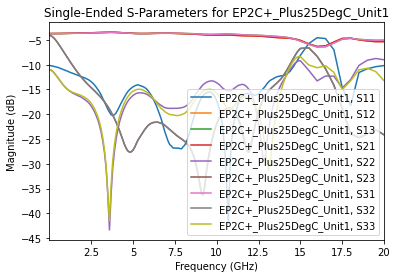

In [1]:
import skrf
import matplotlib.pyplot as plt
import numpy as np

filename = r'mixedmodeSandZtransform_files/EP2C+_Plus25DegC_Unit1.S3P'
se_ntwk = skrf.Network(filename)
se_ntwk.frequency.unit = 'GHz'

# plot single-ended s-parameters
fig,ax0 = plt.subplots(1)
se_ntwk.plot_s_db(ax=ax0)
ax0.set_title(f'Single-Ended S-Parameters for {se_ntwk.name}')

# use the same frequency list for all networks
freq = se_ntwk.frequency

3-Port Network: 'EP2C+_Plus25DegC_Unit1',  0.01-20.0 GHz, 169 pts, z0=[ 50.+0.j 100.+0.j  25.+0.j]


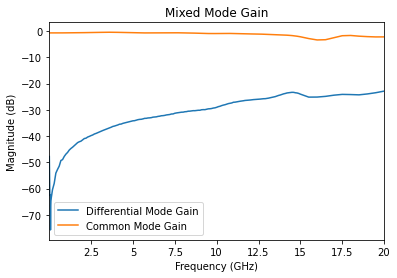

In [2]:
# convert to mixed-mode s-parameters
mm_ntwk = se_ntwk.copy()

# for a 3-port, the common port has to be the last
mm_ntwk.renumber([0,1,2],[2,1,0]) 
mm_ntwk.se2gmm(p=1)

# make the differential mode port and common mode ports consistent with the figure above
mm_ntwk.renumber([2,1,0],[0,2,1])

fig,ax1 = plt.subplots(1)
mm_ntwk.plot_s_db(1,0,label='Differential Mode Gain',ax=ax1)
mm_ntwk.plot_s_db(2,0,label='Common Mode Gain',ax=ax1)
ax1.set_title('Mixed Mode Gain')

print(mm_ntwk)

In [3]:
# create a 25 to 50 ohm transformer

# turns ratio
n = 2

# ABCD Parameters
a = np.array([[n, 0], [0, 1/n]])[np.newaxis, :, :]
abcd = np.tile(a, [freq.npoints, 1, 1])

transformer = skrf.Network(name='transformer',frequency=freq)
transformer.s = skrf.a2s(abcd, z0=[50, 50])

# connect the transformer to the common mode port
# common mode port impedance transformed from 50 ohms to 25 ohms
mm_ntwk_t = skrf.connect(mm_ntwk,2,transformer,1)

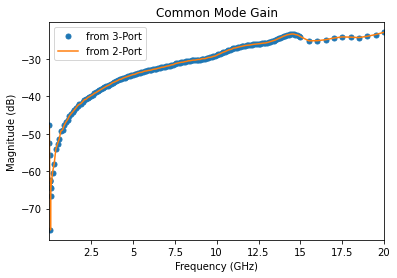

In [4]:
# create a 100 ohm termination
term = skrf.Network(name='100 ohm termination',z0=100,
                    s=np.zeros([mm_ntwk.frequency.npoints]),
                    frequency=mm_ntwk.frequency)

# connect the 100 ohm termination to the differential mode port
mm_ntwk_2port = skrf.connect(mm_ntwk_t,1,term,0)

fig,ax2 = plt.subplots(1)
mm_ntwk.plot_s_db(1,0,label='from 3-Port',ax=ax2,marker='o',lw=0,markersize=5)
mm_ntwk_2port.plot_s_db(1,0,label='from 2-Port',ax=ax2)

ax2.set_title('Common Mode Gain');

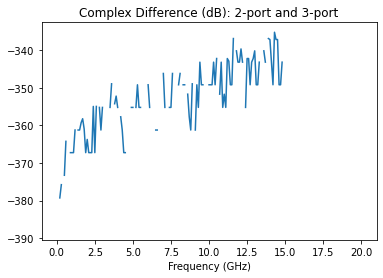

In [5]:
# compare the common mode gain of the impedance transformed 2-port to the mixed-mode untransformed 3-port
complex_diff = np.abs(mm_ntwk_2port.s[:,1,0] - mm_ntwk.s[:,1,0])

# don't give warning for -inf
complex_diff[complex_diff==0] = np.nan

fig,ax3 = plt.subplots(1)
plt.plot(freq.f_scaled,20*np.log10(complex_diff))
ax3.set_title('Complex Difference (dB): 2-port and 3-port')
ax3.set_xlabel('Frequency (GHz)');